# Memprediksi Timbulnya Diabetes Berdasarkan Tindakan Diagnostik

## Background

Kumpulan data ini aslinya dari Institut Nasional Diabetes dan Penyakit Pencernaan dan Ginjal. Tujuan dari kumpulan data adalah untuk memprediksi secara diagnostik apakah seorang pasien menderita diabetes atau tidak, berdasarkan pengukuran diagnostik tertentu yang termasuk dalam kumpulan data. Beberapa kendala ditempatkan pada pemilihan contoh ini dari database yang lebih besar. Secara khusus, semua pasien di sini adalah wanita yang berusia minimal 21 tahun dari warisan Indian Pima.

Dataset terdiri dari beberapa variabel prediktor medis dan satu variabel target, Hasil. Variabel prediktor meliputi jumlah kehamilan yang dialami pasien, BMI mereka, tingkat insulin, usia, dan sebagainya.

### Acknownlegdements

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.


## Import Packages and Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pydotplus
import seaborn as sns
import sklearn.tree as tree

from IPython.display import Image
from six import StringIO
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
plt.style.use("ggplot")

## Load Data and Exploratory Data Analysis

In [2]:
dataset = pd.read_csv("./dataset/diabetes.csv", sep=',')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
dataset.shape

(768, 9)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Terdapat 9 variable dalam dataset berdasarkan tindakan diagnostik yang memungkinkan dapat menjadi penyebab pasien diabetes yaitu:
1. Pregnancies, berapa kali seorang pasien mengalami kehamilan
2. Glucose, konsentrasi glukosa plasma 2 jam dalam tes toleransi glukosa oral
3. Blood Pressure, tekanan darah diastolik (mm Hg)
4. Skin Thickness, ketebalan lipatan kulit trisep (mm)
5. Insulin, insulin serum 2 jam (mu U / ml)
6. BMI (Body Mass Index), indes massa tubuh (berat dalam kg / (tinggi dalam m) ^ 2)
7. Diabetes Pedigree Function, fungsi silsilah diabetes
8. Age, usia (tahun)
9. Outcome, label

### Missing Values

In [5]:
dataset.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

Berdasarkan keterangan diatas dapat dilihat bahwa tidak ada missing value didalam dataset yang dimiliki.

In [6]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


0    500
1    268
Name: Outcome, dtype: int64

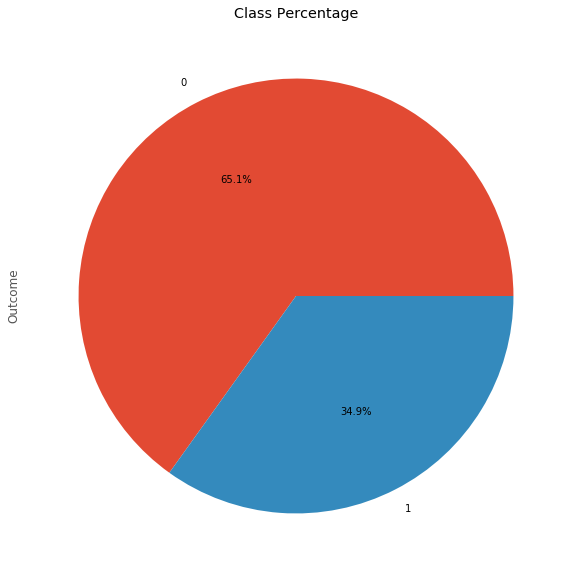

In [7]:
dataset['Outcome'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(10,10)
)
plt.title("Class Percentage")
dataset['Outcome'].value_counts()

Persentase kelas diatas menunjukkan bahwa :
1. Jumlah pasien negative diabetes ada 500 pasien dan pasien positive diabetes ada 268 
2. Pasien yang negative diabetes ada 65.1% dari keseluruhan data
3. Pasien yang positive diabetes ada 34.9% dari keseluruhan data

Hal tersebut menunjukkan bahwa dataset imbalance tetapi pada case ini tidak akan dilakukan oversampling terhadap data kelas negative dengan anggapan bahwa dengan sedikitnya data yang dimiliki maka penambahan data baru secara duplicates maupun dengan perhitungan lainnya akan membuat dataset memiliki data baru yang sama saja beserta data baru yang tidak memiliki validasi berdasarkan tindakan diagnostik.

In [8]:
dataset.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Pearson Correlation

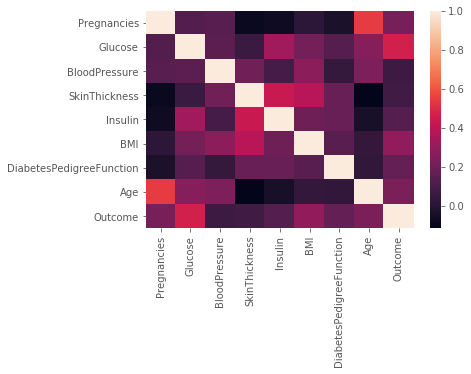

In [9]:
df_corr = dataset.corr()
sns.heatmap(df_corr)

In [10]:
df_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


Dari visualisasi nilai korelasi pearson dari setiap variabel terhadap variabel lainnya dapat dikatakan bahwa:

1. Korelasi independent variable terhadap dependent variable berada di rentang 0 sampai 1 
2. Independent variable yang bisa dikatakan paling kuat berkorelasi dengan dependent variable adalah variabel Glucose
3. Independent variable yang bisa dikatakan kurang berkorelasi atau berkorelasi rendah dengan dependent variable adalah variabel BloodPressure

In [11]:
label = dataset['Outcome']
data = dataset.loc[:, dataset.columns != 'Outcome']
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


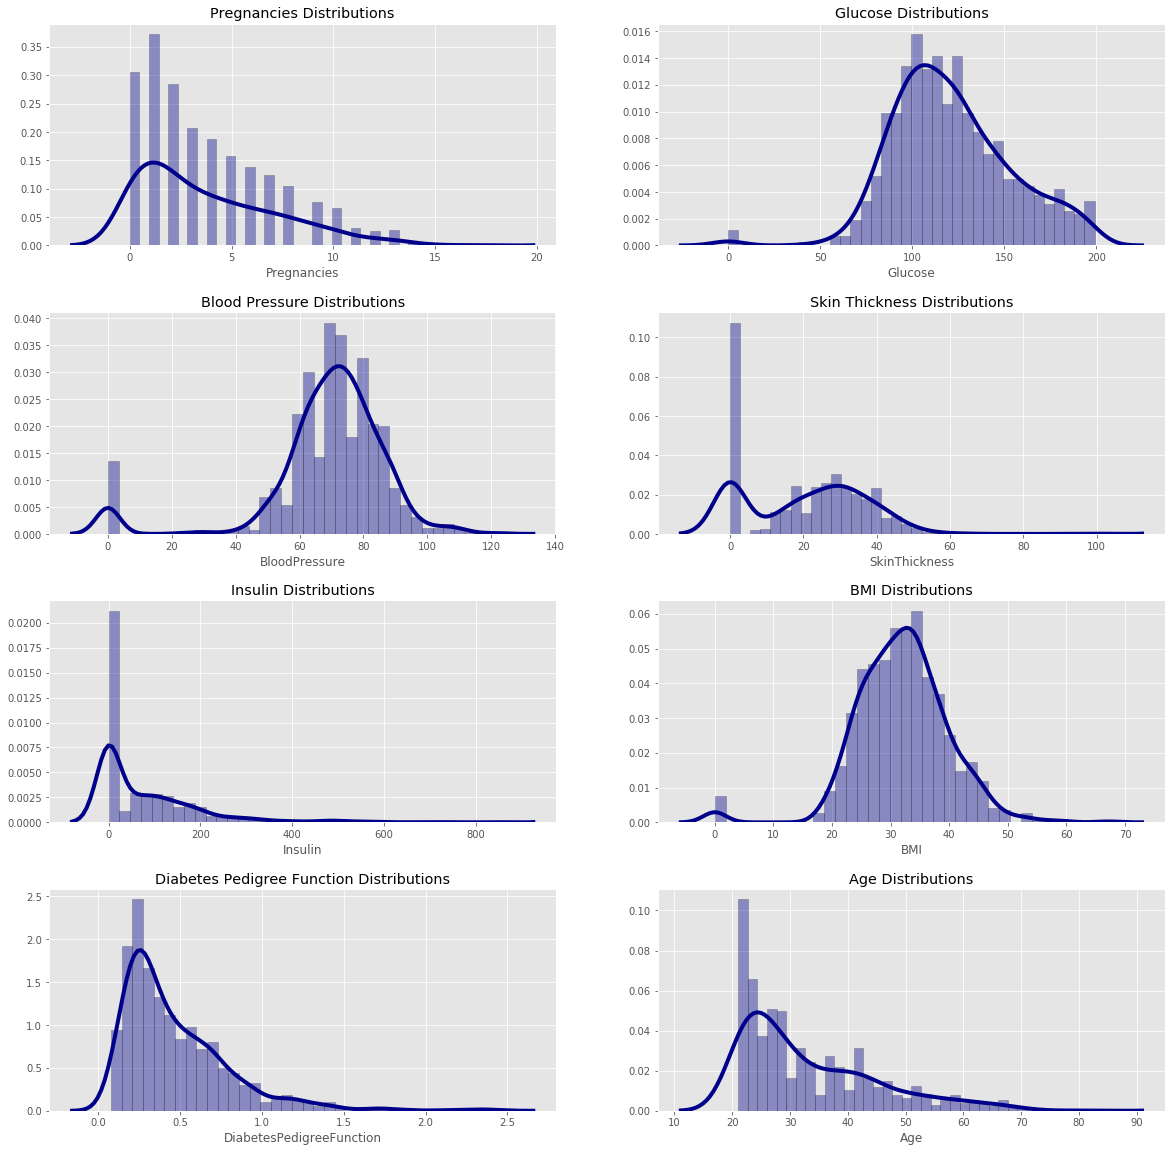

In [12]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

ax1 = sns.distplot(data['Pregnancies'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax1)
ax1.set_title("Pregnancies Distributions")

ax2 = sns.distplot(data['Glucose'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax2)
ax2.set_title("Glucose Distributions")

ax3 = sns.distplot(data['BloodPressure'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax3)
ax3.set_title("Blood Pressure Distributions")

ax4 = sns.distplot(data['SkinThickness'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax4)
ax4.set_title("Skin Thickness Distributions")

ax5 = sns.distplot(data['Insulin'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax5)
ax5.set_title("Insulin Distributions")

ax6 = sns.distplot(data['BMI'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax6)
ax6.set_title("BMI Distributions")

ax7 = sns.distplot(data['DiabetesPedigreeFunction'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax7)
ax7.set_title("Diabetes Pedigree Function Distributions")

ax8 = sns.distplot(data['Age'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax=ax8)
ax8.set_title("Age Distributions")

fig.subplots_adjust(hspace=0.3)

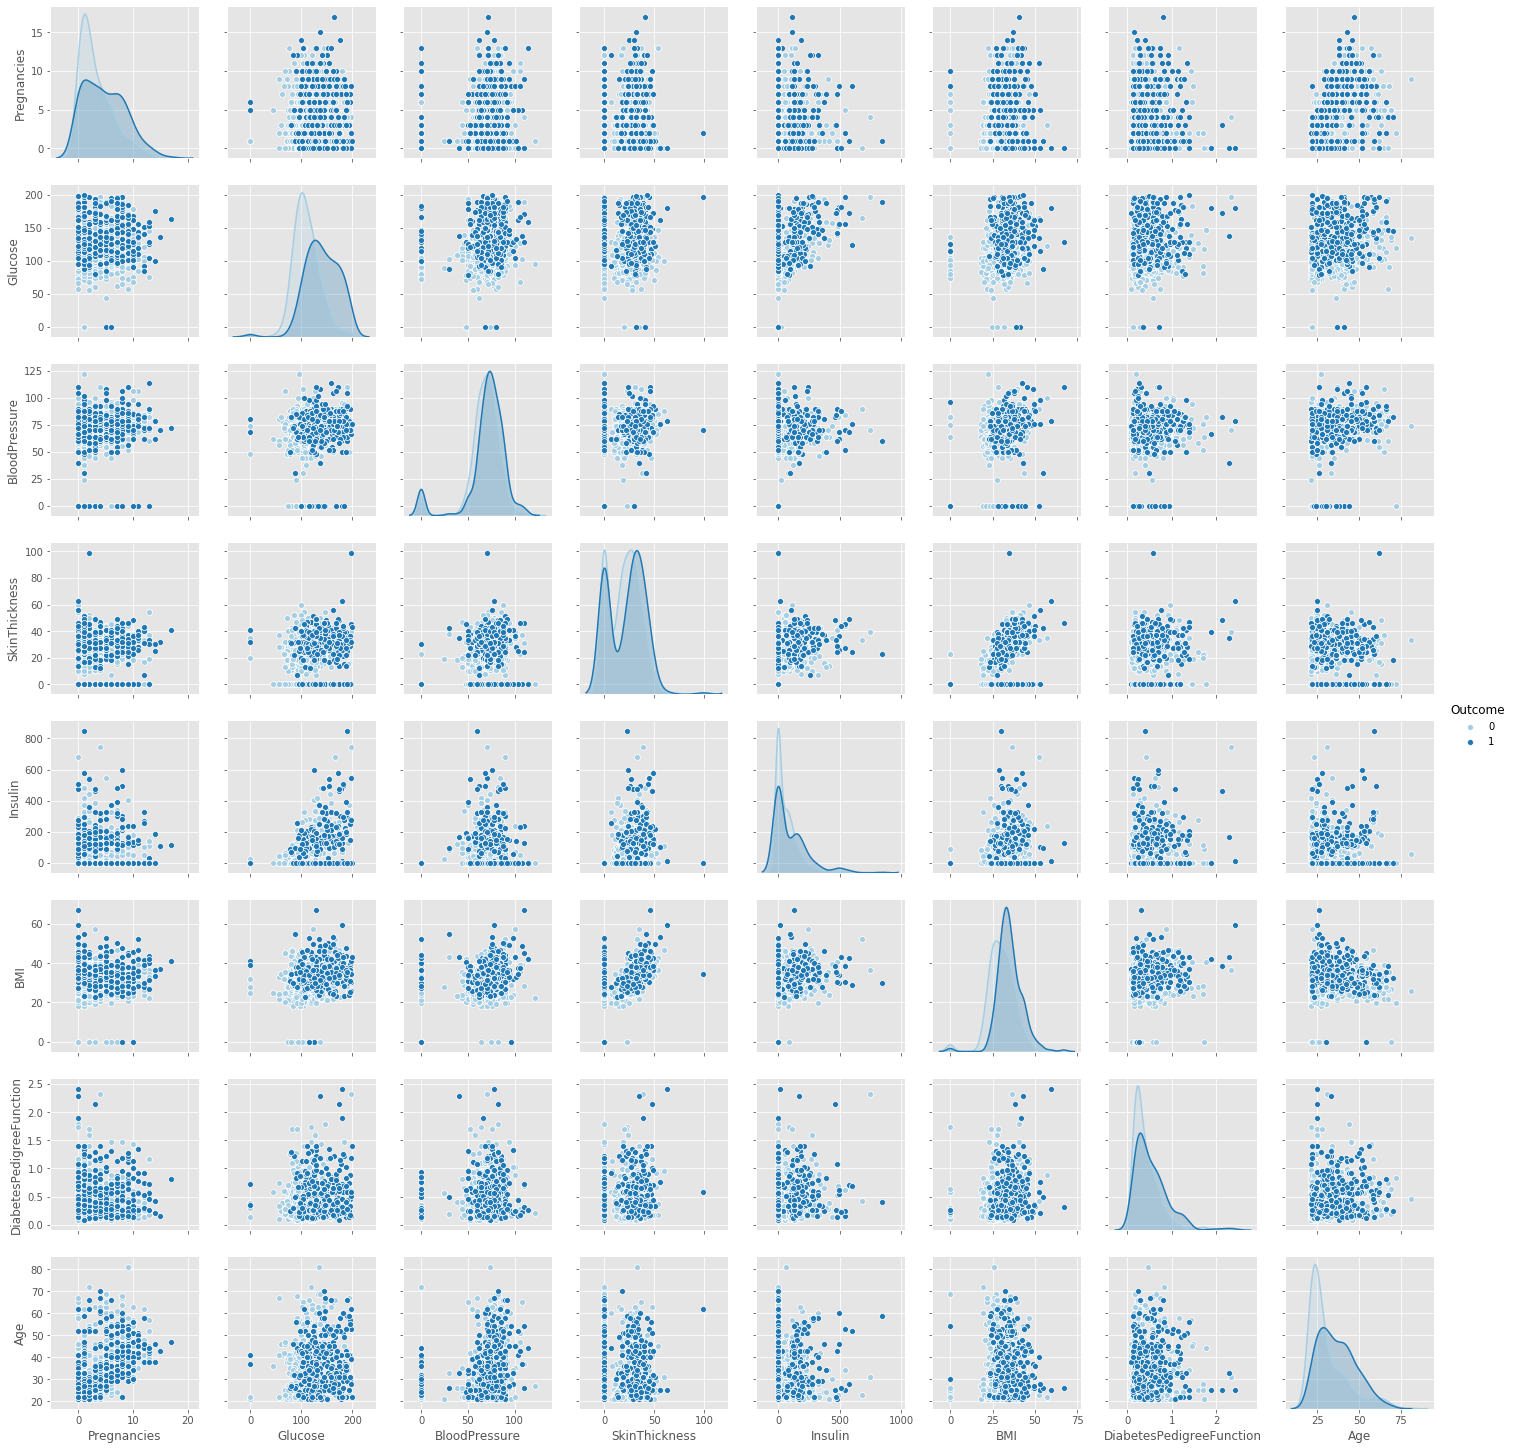

In [13]:
 pair_plot = sns.pairplot(dataset, hue="Outcome", palette="Paired")

## Outliers

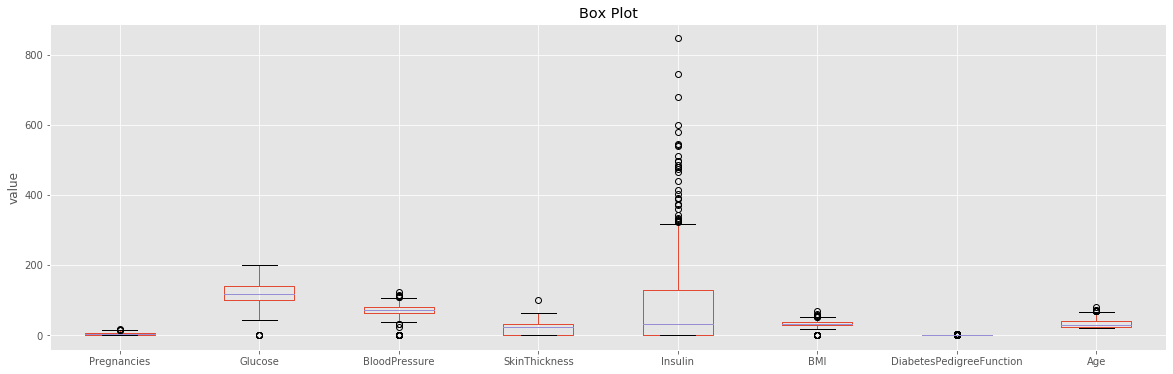

In [14]:
data.plot(
            kind="box",
            figsize=(20, 6)
        )

# Graded-Funtion End
plt.title('Box Plot')
plt.ylabel('value')

plt.show()

In [15]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


Dari boxplot diatas dapat dikatakan bahwa:
1. Pregnancies memiliki nilai max yang sangat besar dan memiliki jarak yang cukup jauh dengan percentile lainnya.
2. Glucose memiliki nilai min 0 yang jauh dari rata-rata, sehingga data tersebut bisa dianggap sebagai outlier, berdasarkan visualisasi distribusinya terdapat 2 puncak yang dimana satu puncak nya berada di 0 dipastikan data tersebut dikarenakan adanya outlier.
3. Sama halnya dengan Glucose, Blood Pressure, Skin Thickness, Insulin dan BMI memeiliki 2 puncak pada visualisasi distribusinya dikarenakan adanya outlier

#### Remove Outliers

In [16]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR)))
data.shape

Pregnancies                   5.0000
Glucose                      41.2500
BloodPressure                18.0000
SkinThickness                32.0000
Insulin                     127.2500
BMI                           9.3000
DiabetesPedigreeFunction      0.3825
Age                          17.0000
dtype: float64
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0          False    False          False          False    False  False   
1          False    False          False          False    False  False   
2          False    False          False          False    False  False   
3          False    False          False          False    False  False   
4          False    False          False          False    False  False   
..           ...      ...            ...            ...      ...    ...   
763        False    False          False          False    False  False   
764        False    False          False          False    False  False   
765        Fal

(768, 8)

In [17]:
data_clean = dataset[~((dataset < (Q1 - 1.5 * IQR)) |(dataset > (Q3 + 1.5 * IQR))).any(axis=1)]
data_clean.shape

(639, 9)

In [18]:
data_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0


## Preprocessing

In [19]:
# Split Data
x = data_clean.loc[:, data_clean.columns != 'Outcome']
y = data_clean['Outcome']
print("X Shape :", x.shape, "Y Shape :", y.shape)

x = StandardScaler().fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=.2,
    random_state=11
)
print("Training size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

X Shape : (639, 8) Y Shape : (639,)
Training size: 511
Test size: 128


## Classification 

In [20]:
def train_model(model, X_train, X_test, y_train, y_test):
    model = model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_acc = model.score(X_train, y_train)
    train_f1 = f1_score(y_train, train_pred)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)

    test_pred = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    test_f1 = f1_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)

    print("==== Training Performance ====")
    print("Accuracy Score:", train_acc)
    print("F1 Score:", train_f1)
    print("Precision Score:", train_precision)
    print("Recall Score:", train_recall)
    
    print()
    print("==== Test Performance ====")
    print("Accuracy Score:", test_acc)
    print("F1 Score:", test_f1)
    print("Precision Score:", test_precision)
    print("Recall Score:", test_recall)
    
    print()
    print(classification_report(y_test, test_pred))
    #print(confusion_matrix(y_test, test_pred))
    return test_acc, test_recall, model

### Logistic Regression

In [21]:
logistic = LogisticRegression()
logReg_acc, logReg_recall, model_log = train_model(logistic, X_train, X_test, y_train, y_test)

==== Training Performance ====
Accuracy Score: 0.7906066536203522
F1 Score: 0.610909090909091
Precision Score: 0.7241379310344828
Recall Score: 0.5283018867924528

==== Test Performance ====
Accuracy Score: 0.8125
F1 Score: 0.6470588235294118
Precision Score: 0.8148148148148148
Recall Score: 0.5365853658536586

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        87
           1       0.81      0.54      0.65        41

    accuracy                           0.81       128
   macro avg       0.81      0.74      0.76       128
weighted avg       0.81      0.81      0.80       128



### KNearestNeighbor

In [22]:
knn = KNeighborsClassifier()
knn_acc, knn_recall, model_knn = train_model(knn, X_train, X_test, y_train, y_test)

==== Training Performance ====
Accuracy Score: 0.8160469667318982
F1 Score: 0.6690140845070424
Precision Score: 0.76
Recall Score: 0.5974842767295597

==== Test Performance ====
Accuracy Score: 0.765625
F1 Score: 0.5945945945945946
Precision Score: 0.6666666666666666
Recall Score: 0.5365853658536586

              precision    recall  f1-score   support

           0       0.80      0.87      0.84        87
           1       0.67      0.54      0.59        41

    accuracy                           0.77       128
   macro avg       0.73      0.71      0.71       128
weighted avg       0.76      0.77      0.76       128



### Support Vector Machine

In [23]:
svm = SVC()
svm_acc, svm_recall, model_svm = train_model(svm, X_train, X_test, y_train, y_test)

==== Training Performance ====
Accuracy Score: 0.8317025440313112
F1 Score: 0.6742424242424242
Precision Score: 0.8476190476190476
Recall Score: 0.559748427672956

==== Test Performance ====
Accuracy Score: 0.8125
F1 Score: 0.6470588235294118
Precision Score: 0.8148148148148148
Recall Score: 0.5365853658536586

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        87
           1       0.81      0.54      0.65        41

    accuracy                           0.81       128
   macro avg       0.81      0.74      0.76       128
weighted avg       0.81      0.81      0.80       128



### Decision Tree

In [24]:
dst = DecisionTreeClassifier()
dst_acc, dst_recall, model_dst = train_model(dst, X_train, X_test, y_train, y_test)

==== Training Performance ====
Accuracy Score: 1.0
F1 Score: 1.0
Precision Score: 1.0
Recall Score: 1.0

==== Test Performance ====
Accuracy Score: 0.625
F1 Score: 0.4
Precision Score: 0.41025641025641024
Recall Score: 0.3902439024390244

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        87
           1       0.41      0.39      0.40        41

    accuracy                           0.62       128
   macro avg       0.56      0.56      0.56       128
weighted avg       0.62      0.62      0.62       128



### Random Forest

In [25]:
randfor = RandomForestClassifier()
randfor_acc, randfor_recall, model_randfor = train_model(randfor, X_train, X_test, y_train, y_test)

==== Training Performance ====
Accuracy Score: 1.0
F1 Score: 1.0
Precision Score: 1.0
Recall Score: 1.0

==== Test Performance ====
Accuracy Score: 0.7734375
F1 Score: 0.5915492957746479
Precision Score: 0.7
Recall Score: 0.5121951219512195

              precision    recall  f1-score   support

           0       0.80      0.90      0.84        87
           1       0.70      0.51      0.59        41

    accuracy                           0.77       128
   macro avg       0.75      0.70      0.72       128
weighted avg       0.77      0.77      0.76       128



### Naive Bayes

In [26]:
bayes = GaussianNB()
bayes_acc, bayes_recall, model_bayes = train_model(bayes, X_train, X_test, y_train, y_test)

==== Training Performance ====
Accuracy Score: 0.7651663405088063
F1 Score: 0.6153846153846154
Precision Score: 0.6274509803921569
Recall Score: 0.6037735849056604

==== Test Performance ====
Accuracy Score: 0.7734375
F1 Score: 0.6329113924050632
Precision Score: 0.6578947368421053
Recall Score: 0.6097560975609756

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        87
           1       0.66      0.61      0.63        41

    accuracy                           0.77       128
   macro avg       0.74      0.73      0.73       128
weighted avg       0.77      0.77      0.77       128



## Evaluasi Model

Tujuan dari model ini adalah untuk memprediksi munculnya diabetes pada pasien wanita, oleh karena matriks evaluasi yang akan digunakan adalah Recall dan Accuracy.

Summary matriks evaluasi dari classifier yang digunakan adalah sebagai berikut :

1. Classifier Logistic Regression dengan **accuracy dan recall training yaitu 0.790 dan 0.528** dan **accuracy dan recall testing yaitu 0.812 dan 0.536**
2. Classifier KNN dengan **accuracy dan recall training yaitu 0.816 dan 0.597** dan **accuracy dan recall testing yaitu 0.765 dan 0.536**
3. Classifier SVM dengan **accuracy dan recall training yaitu 0.832 dan 0.560** dan **accuracy dan recall testing yaitu 0.812 dan 0.536**
4. Classifier DST dengan **accuracy dan recall training yaitu 1.0 dan 1.0** dan **accuracy dan recall testing yaitu 0.625 dan 0.390**
5. Classifier Random Forest dengan **accuracy dan recall training yaitu 1.0 dan 1.0** dan **accuracy dan recall testing yaitu 0.773 dan 0.512**
6. Classifier Naive Bayes dengan **accuracy dan recall training yaitu 0.765 dan 0.604** dan **accuracy dan recall testing yaitu 0.77 dan 0.609**




#### Visualization

In [27]:
summary = pd.DataFrame({
    "Classifier" : ["Logistic Regression", "KNN", "SVM", "DST", "Random Forest", "Naive Bayes"],
    "Accuracy Score": [logReg_acc, knn_acc, svm_acc, dst_acc, randfor_acc, bayes_acc],
    "Recall Score": [logReg_recall, knn_recall, svm_recall, dst_recall, randfor_recall, bayes_recall]
})

summary

,Classifier,Accuracy Score,Recall Score
0,Logistic Regression,0.812500,0.536585
1,KNN,0.765625,0.536585
2,SVM,0.812500,0.536585
3,DST,0.625000,0.390244
4,Random Forest,0.773438,0.512195
5,Naive Bayes,0.773438,0.609756


## Model Saving

In [28]:
pickle.dump(model_bayes, open("./best_model_prediksi_diabetes.pkl", "wb"))

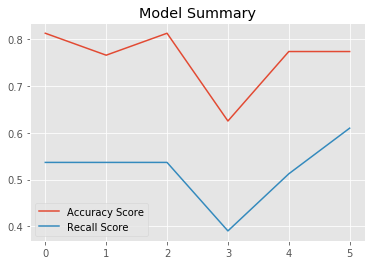

In [29]:
summary.plot(
    kind = 'line',
    title = 'Model Summary'
)

## Kesimpulan

Berdasarkan hasil training dan testing model diatas dapat disimpulkan bahwa :

1. Model dengan menggunakan classifier jenis Tree menghasilkan hasil yang overfitting, artinya jarak dari hasil training dan testing berbeda jauh dengan hasil training yang sangat baik yaitu 100% berbeda dengan hasil testingnya kurang dari ~70%.

2. Classifier yang terbaik dengan Recall yang paling tinggi dan accuracy yang cukup baik terhadap data test adalah **Naive Bayes Classifier** 

3. Model ini dapat dikembangkan kembali agar mendapatkan performansi yang baik. Baik itu dengan hyperparameter tunning, maupun dengan classifier lainnya.